# Check of postode quality
## Preparation

In [1]:
# packages import
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

In [2]:
# versions of packages
print(pd.__version__)
print(np.__version__)
import matplotlib
print(matplotlib.__version__)

1.5.0
1.23.3
3.6.0


In [3]:
# some functions needed for analysis

def get_quantile(list, value):
    '''
    Return the quantile of that value between 0 and 100 (no rounding)
    '''
    return np.round((list < value).mean() * 100 ,0)

def plot_hist(
    serie,
    value,
    title):
    '''
    Create a histogram with vertical line
    '''
    plt.hist(
        serie,
        bins = 20,
        color = 'mediumturquoise',
        edgecolor = 'teal',
        alpha = 0.65,
    )
    plt.axvline(
        value,
        color = 'red',
        linestyle = 'dashed'
    )
    min_ylim, max_ylim = plt.ylim()
    plt.text(
        value*1.1,
        max_ylim*0.9, 
        ' Val: {:.2f}'.format(value))
    plt.title(title)
    plt.show()

In [4]:
# Read final data
data = pd.read_csv(
    "data/main_data.zip"
)

## Analysis

### postcode input

In [5]:
my_postcode = "LS28 7AA"

### Results

In [6]:
# get postcode line
get_data = data[data["pcds"] == my_postcode]

# get district
data['my_district'] = (data['district'] == get_data['district'].to_list()[0]).astype(int)

In [7]:
# results
dict_floor = {
    0 : 'None',
    1 : 'Very Low',
    2 : 'Low',
    3 : 'Medium',
    4 : 'High'
}

print(f"""GENERAL INFO FOR POSTCODE {my_postcode}:

The LSOA is {get_data['lsoa11'].to_list()[0]}

The district is {get_data['district'].to_list()[0]}

The sector is {get_data['sector'].to_list()[0]}

The risk of flooding is set to '{get_data['flood_risk_int'].map(dict_floor).to_list()[0]}'. ({get_data['flood_value_from'].to_list()[0]})

The postcode is at {get_data['elevation'].to_list()[0]}m above the sea level. ({get_data['elevation_value_from'].to_list()[0]})

We have {get_data['estimated_cat_population'].to_list()[0]} cats in the district. ({get_data['pets_value_from'].to_list()[0]})
This is the {get_quantile( data['estimated_cat_population'], get_data['estimated_cat_population'].to_list()[0] )}th quantile in the cats' values distribution.

We have on avg {get_data['dog_per_household_lower95'].to_list()[0]} dogs by house in the district. ({get_data['pets_value_from'].to_list()[0]})
This is the {get_quantile( data['dog_per_household_lower95'], get_data['dog_per_household_lower95'].to_list()[0] )}th quantile in the dogs' values distribution.
""")

GENERAL INFO FOR POSTCODE LS28 7AA:

The LSOA is E01011612

The district is LS28

The sector is LS

The risk of flooding is set to 'None'. (raw_postcode)

The postcode is at 160.0m above the sea level. (raw_postcode)

We have 7763.99 cats in the district. (raw_district)
This is the 83.0th quantile in the cats' values distribution.

We have on avg 0.4560508 dogs by house in the district. (raw_district)
This is the 68.0th quantile in the dogs' values distribution.



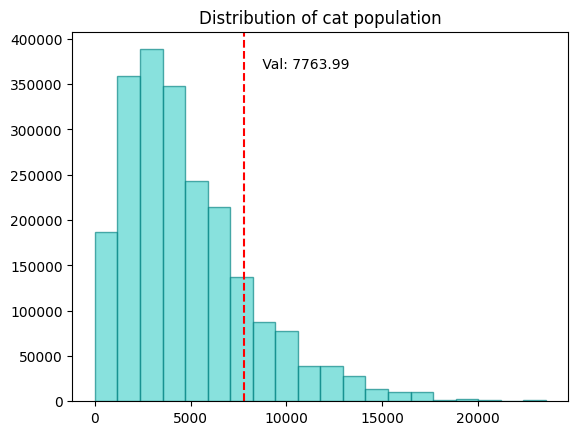

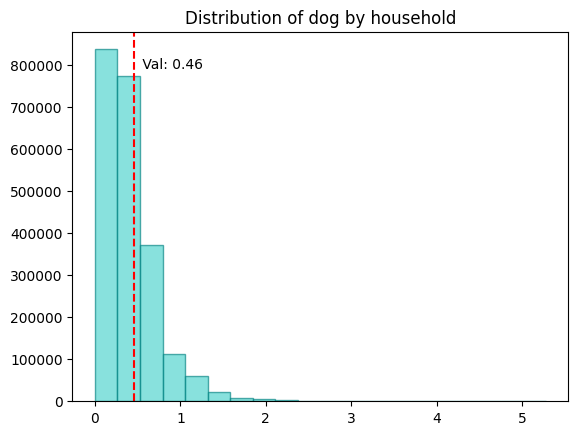

In [8]:
# histogram of cat by district and red vertical line where our value is
plot_hist(
    serie = data['estimated_cat_population'],
    value = get_data['estimated_cat_population'].to_list()[0],
    title = 'Distribution of cat population')

# Same with dogs
plot_hist(
    serie = data['dog_per_household_lower95'],
    value = get_data['dog_per_household_lower95'].to_list()[0],
    title = 'Distribution of dog by household')


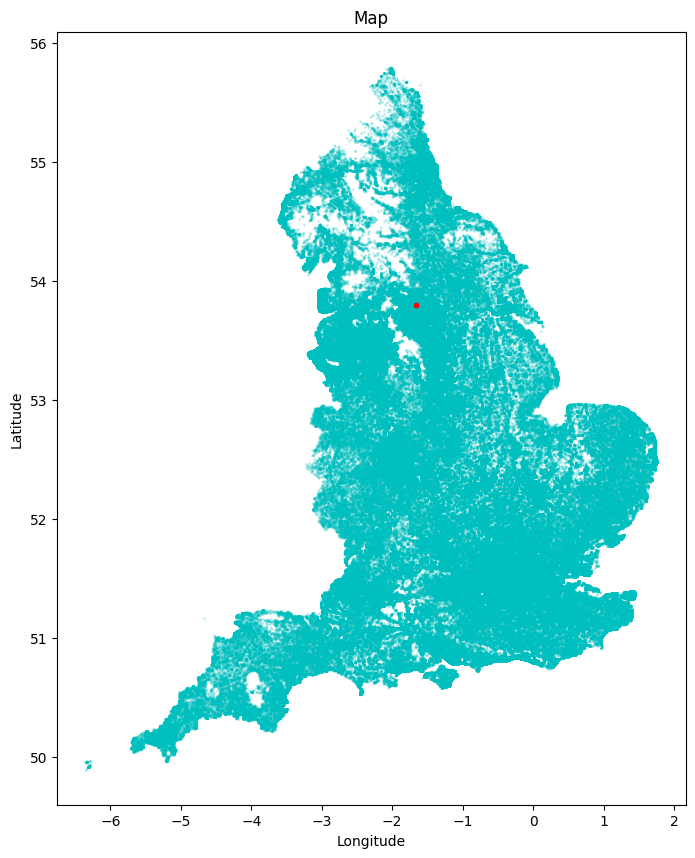

In [9]:
# map where the postcode is
range_longitude = data['long'].max() - data['long'].min()
range_latitude = data['lat'].max() - data['lat'].min()

figure_width = np.max(
    [ range_longitude, 2]
)
figure_height = 1.7 * range_latitude * figure_width / range_longitude
fig, ax = plt.subplots( figsize = (figure_width, figure_height) )

# create district data - such that we do not overwhelm the map with points
district_data = data.groupby('district').\
    agg({
        'long': 'mean',
        'lat': 'mean',
        'my_district': 'mean',
        }
    )

plt.scatter(
    x = data['long'],
    y = data['lat'],
    alpha = 0.2,
    c = 'c',
    s = 1,
    #cmap = 'bwr',
    plotnonfinite = True
)
plt.scatter(
    x = get_data['long'],
    y = get_data['lat'],
    c = 'r',
    s = 10,
    #cmap = 'bwr',
    plotnonfinite = True
)

ax = plt.gca()
plt.title("Map")
plt.xlabel("Longitude")
plt.ylabel("Latitude");

In [10]:
print(f"""
Since the 1970s the Ministry of Housing, Communities and Local Government and its predecessors
have calculated local measures of deprivation in England.
There are 32844 areas in England, all listed from 1 (worst) to 32844 (best).
There are 7 domains of deprivation, which combine to create the Global one:
- Income
- Employment
- Education
- Health
- Crime
- Barriers to Housing and Services
- Living Environment

Globally the postcode's IMD ranking is {get_data['imd_global_rank'].to_list()[0]} - aka {np.round(get_data['imd_global_rank'].to_list()[0] / 32844 * 100,2)}th quantile
""")

for cat in [
    'income',
    'employment',
    'education',
    'health',
    'crime',
    'services',
    'living_environment']:
    print(f"The {cat} IMD ranking is {get_data['imd_' + cat + '_rank'].to_list()[0]} - aka {np.round(get_data['imd_' + cat + '_rank'].to_list()[0] / 32844 * 100,2)}th quantile")
    


Since the 1970s the Ministry of Housing, Communities and Local Government and its predecessors
have calculated local measures of deprivation in England.
There are 32844 areas in England, all listed from 1 (worst) to 32844 (best).
There are 7 domains of deprivation, which combine to create the Global one:
- Income
- Employment
- Education
- Health
- Crime
- Barriers to Housing and Services
- Living Environment

Globally the postcode's IMD ranking is 8564 - aka 26.07th quantile

The income IMD ranking is 10113 - aka 30.79th quantile
The employment IMD ranking is 9232 - aka 28.11th quantile
The education IMD ranking is 11866 - aka 36.13th quantile
The health IMD ranking is 6630 - aka 20.19th quantile
The crime IMD ranking is 3892 - aka 11.85th quantile
The services IMD ranking is 30059 - aka 91.52th quantile
The living_environment IMD ranking is 4546 - aka 13.84th quantile
